In [ ]:
import PIL
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms.functional as TF
from torchvision import transforms
import torchvision.transforms.v2 as v2
from torchvision.transforms import InterpolationMode
import shelve
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from pathlib import Path
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Setup

In [ ]:
images_train_path = '/content/gdrive/MyDrive/archive/archive/Training' # change path if different

In [ ]:
# define map so labels can created
map = {
    'glioma': 0,
    'meningioma': 1,
    'notumor': 2,
    'pituitary': 3,
    }

In [ ]:
# make a list of tuples (filepath, label)
tumors = []
for i, name in enumerate(map.keys()):
  folder = os.listdir(os.path.join(images_train_path, name))
  for filename in folder:
    tumors.append((os.path.join(images_train_path, name, filename), map[name]))

# Dataset Class

In [ ]:
# dataset class
class vit_dset(Dataset):
    def __init__(self, info, mode='default'):
        self.data = info
        self.mode = mode
    def __len__(self):
      return len(self.data)
    def __getitem__(self, idx):
        # get info from list of tuples
        pic = self.data[idx][0]
        lbl = self.data[idx][1]

        # since greyscale, all 3 channels should have same intensity, so take mean of per-channel normalizations
        mean = [np.mean([0.485, 0.456, 0.406])] * 3
        std = [np.mean([0.229, 0.224, 0.225])] * 3

        # mean = [0.485, 0.456, 0.406]
        # std = [0.229, 0.224, 0.225]

        # open 1 channel greyscale as 3 channel rgb, still the same pic, just diff opening process
        image = PIL.Image.open(pic).convert('L')
        image_np = np.array(image)
        image_rgb = np.stack([image_np, image_np, image_np], axis=-1)
        preprocess = v2.Compose([ # processing specific to VIT
            v2.ToImage(),
            v2.Resize(256, interpolation=InterpolationMode.BILINEAR),
            v2.CenterCrop(224),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=mean, std=std)
        ])

        image = preprocess(image_rgb)

        if self.mode == 'default': # all loops in this code should be using this setting now
          # label is one-hot tensor instead of single value
          label = torch.tensor([0, 0, 0, 0])
          label[lbl] = 1
        else:
          label = torch.tensor(lbl)

        return {'image': image.float(), 'label': label.float()}

# Needed for ckpt loading / training setup

In [ ]:
# set model, criterion, optim
model = torchvision.models.vit_b_32(weights="DEFAULT")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:04<00:00, 82.2MB/s]


In [ ]:
# set trainloader and move to gpu
dset = vit_dset(tumors)
trainloader = DataLoader(dset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('done!')

done!


In [ ]:
# IMPORTANT: change ViT's 1000 classes to 4 classes
infeats = model.heads.head.in_features
replacement = nn.Linear(infeats, 4)
model.heads.head = replacement
model.to(device)
print('done!')

done!


# Training

In [ ]:
# training loop
loss_mem = []
model.train()
num_epochs = 5

for epoch in range(num_epochs):
  for data in tqdm(trainloader):
    image = data['image'].to(device)
    label = data['label'].to(device)

    optimizer.zero_grad()
    out = model(image)
    loss = criterion(out, label)

    loss.backward()
    optimizer.step()

    loss_mem.append(loss.data.item())

  # save checkpoint, IMPORTANT: change name new version / diff model
  path = "/content/gdrive/My Drive/checkpoints/brain_v0_tta_ViT_{0}.ckpt".format(epoch) # look up format in python if unsure
  torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              }, path)

  0%|          | 0/212 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 212/212 [01:15<00:00,  2.79it/s]


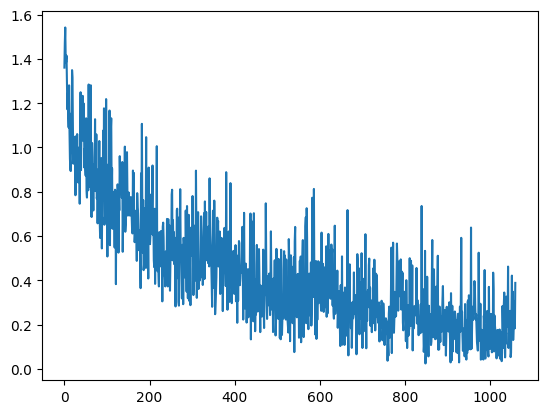

In [ ]:
# plot loss over time
# 212 iters but each batch is 32, so ~7000 pics were processed per epoch
plt.plot(loss_mem)

# Loading checkpoint (optional)

In [ ]:
# loading in previous models, un/re comment if needed
# MUST have optimizer, loss, and model with last layer changed ran before this block
ckpt_path = '/content/gdrive/MyDrive/checkpoints/brain_v0_tta_ViT_4.ckpt' # change path
checkpoint = torch.load(ckpt_path, map_location=torch.device(device))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']

# Testing

In [ ]:
images_test_path = '/content/gdrive/MyDrive/archive/archive/Testing' # change path if different

In [ ]:
# make a list of tuples (filepath, label)
test_tumors = []
for i, name in enumerate(map.keys()):
  folder = os.listdir(os.path.join(images_test_path, name))
  for filename in folder:
    test_tumors.append((os.path.join(images_test_path, name, filename), map[name]))

In [ ]:
test_dset = vit_dset(test_tumors)
test_trainloader = DataLoader(test_dset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print('done!')

done!


In [ ]:
# eval loop, TTA-less
y_true = []
y_pred = []

with torch.no_grad():
    for data in tqdm(test_dset): # ended up not using trainloader since it made evaluation simpler for me
        image = data['image'].unsqueeze(0).to(device) # use unsqueeze since dset outputs chw instead of nchw
        label = data['label']

        output = model(image)
        output = output.softmax(dim=-1)

        y_true.append(torch.argmax(label).numpy())
        y_pred.append(torch.argmax(output).numpy())

100%|██████████| 1351/1351 [06:26<00:00,  3.49it/s]


In [ ]:
# define accuracy evaluation model
def eval(y_true, y_pred):
  assert len(y_true) == len(y_pred)
  total = len(y_true)
  correct = 0

  for i in range(total):
    gt = y_true[i]
    pred = y_pred[i]

    if gt == pred:
      correct += 1

  print(float(correct) / total)

In [ ]:
eval(y_true, y_pred)

0.8897113249444856


# Experiment: TTA

In [ ]:
# define tta transformations
class NoOperation: # still want to include the original image in the tta assembly, so have identity function
    def __call__(self, image):
        return image

tta_transforms = [
    v2.RandomRotation(degrees=10),
    v2.RandomHorizontalFlip(p=1),
    v2.RandomErasing(p=1, value='random', scale=(0.035, 0.035), ratio=(1, 1)),
    NoOperation(),
]

In [ ]:
# tta eval
tta_true = []
tta_pred = []

with torch.no_grad():
    for data in tqdm(test_dset):
      image = data['image'] # dont need to unsqueeze since torch.stack will add nchw to chw tensor
      label = data['label']

      augs = torch.stack([t(image) for t in tta_transforms]).to(device)  # tta for 4 alterations
      outputs = model(augs)
      preds = torch.argmax(outputs, dim=1)
      counts = torch.bincount(preds)

      tta_true.append(torch.argmax(label).item())
      tta_pred.append(torch.argmax(counts).item())

100%|██████████| 1351/1351 [24:41<00:00,  1.10s/it]

0.8978534418948927


In [ ]:
eval(tta_true, tta_pred)

0.8978534418948927


# Visualizations

In [ ]:
# recollect info
test_losses = []
test_accuracies = []
predictions = []
true_labels = []

test_loss = 0.0
correct_test = 0
total_test = 0
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

conf_matrix = np.zeros((4, 4), dtype=int)

with torch.no_grad():
    for data in tqdm(test_trainloader):
        images, labels = data['image'].to(device), torch.argmax(data['label'], dim=1).to(device)
        outp = model(images)
        loss = criterion(outp, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outp, 1)
        predicted = predicted.unsqueeze(1)

        conf_matrix += confusion_matrix(labels.cpu(), predicted.cpu(), labels=[0, 1, 2, 3])

        total_test += labels.size(0)
        correct_test += (outp.argmax(1) == labels).sum().item()

        predictions.extend(outp.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    test_loss /= len(test_trainloader)
    test_accuracy = correct_test / total_test

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


  0%|          | 0/43 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 98%|█████████▊| 42/43 [06:43<00:10, 10.41s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 43/43 [06:43<00:00,  9.39s/it]


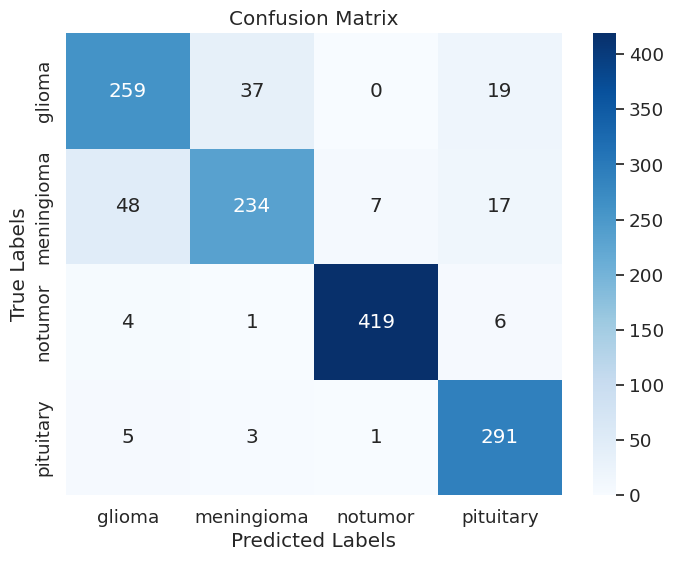

In [ ]:
# make confusion matrix
import seaborn as sns

class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

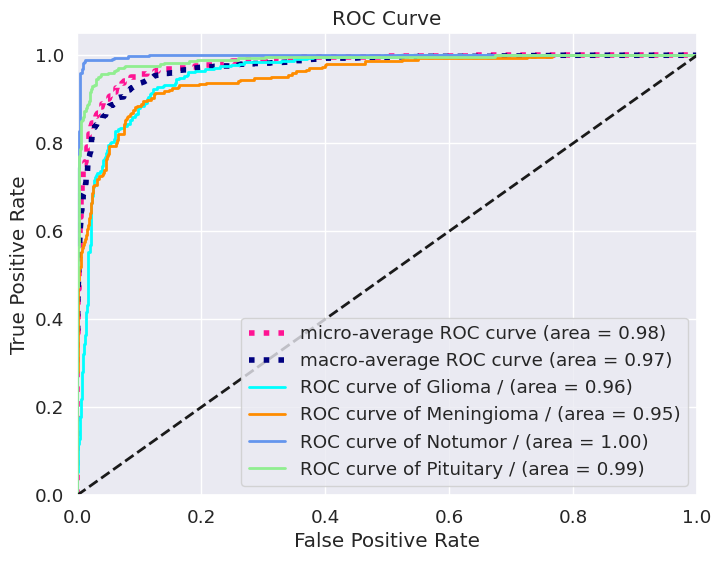

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Function to plot ROC curve
def plot_roc_curve(labels, predictions, num_classes):
    # Binarize the labels
    y_test = label_binarize(labels, classes=range(num_classes))
    n_classes = y_test.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','lightgreen'])
    class_names = ['Glioma', 'Meningioma', 'Notumor', 'Pituitary']  # Add names for each class
    for i, (color, class_name) in enumerate(zip(colors, class_names)):
      if i < num_classes:  # Ensure i doesn't exceed num_classes
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} / (area = {1:0.2f})'.format(class_name, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(true_labels, predictions, num_classes=4)